# Overview

## Imports and image loading

In [13]:
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from PIL import Image
from PIL import ImageFilter
import PIL.ImageOps
import numpy as np
from scipy import ndimage
from scipy import signal
from skimage.util import random_noise

In [2]:
cam = Image.open('cameraman.tif', mode='r').convert(mode="L")
lena = Image.open('lena.tiff', mode='r').convert(mode="L")
grayscale = Image.open('Grayscale.tif', mode='r').convert(mode="L")

In [3]:
def gaussian_noise(im):
    noisy = random_noise(np.array(im), mode='gaussian', var=0.002)
    return Image.fromarray(np.uint8(noisy*255))

def salt_pepper_noise(im):
    noisy = random_noise(np.array(im), mode='s&p', amount=0.05)
    return Image.fromarray(np.uint8(noisy*255))

def speckle_noise(im):
    noisy = random_noise(np.array(im), mode='speckle', var=0.04)
    return Image.fromarray(np.uint8(noisy*255))

In [4]:
def MSE(im1, im2):
    assert im1.size == im2.size and im1.mode == im2.mode
  
    im1_data = np.array(im1, dtype=np.int32).flatten()
    im2_data = np.array(im2, dtype=np.int32).flatten()
    
    M = len(im1_data)
    
    MSE = np.power(np.subtract(im1_data, im2_data), 2).sum() / M
    return MSE

def PSNR(im1, im2):
    assert im1.size == im2.size and im1.mode == im2.mode
    mse = MSE(im1, im2)
    if mse == 0:
        return math.inf
    return 10 * math.log10(65025.0 / mse) # 255^2 = 65025

def plot_histogram(im, title):
    im_hist = im.histogram()
    plt.bar([i for i in range(256)], im_hist)
    plt.title(title)
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()

# Noise Reduction in the Spatial Domain

PSNR between Lena and noisy Lena: 26.968951065292384


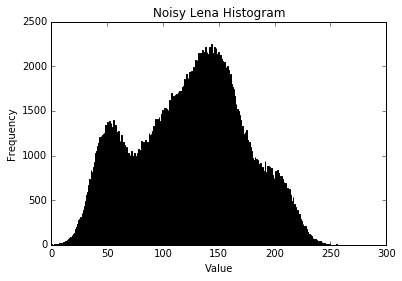

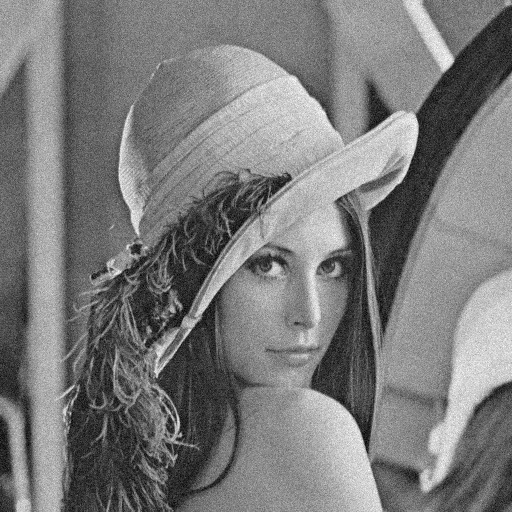

In [5]:
%matplotlib inline
noisy_lena = gaussian_noise(lena)
print("PSNR between Lena and noisy Lena: " + str(PSNR(lena, noisy_lena)))

plot_histogram(noisy_lena, "Noisy Lena Histogram")

noisy_lena

### noisy lena convolved with 3x3 averaging filter

3x3 averaging filter:
PSNR between Lena and averaged Lena: 31.80765460263419



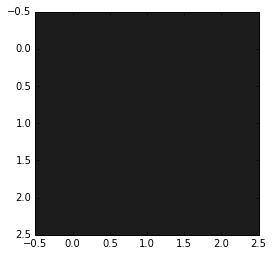

In [6]:
avg_3_3 = (1/9)*np.ones([3,3])

print("3x3 averaging filter:")
imshow(Image.fromarray(avg_3_3 *255))

noisy_lena_avg1 = Image.fromarray(ndimage.convolve(np.array(noisy_lena), avg_3_3), 'L')

print("PSNR between Lena and averaged Lena: " + str(PSNR(lena, noisy_lena_avg1)) + "\n")

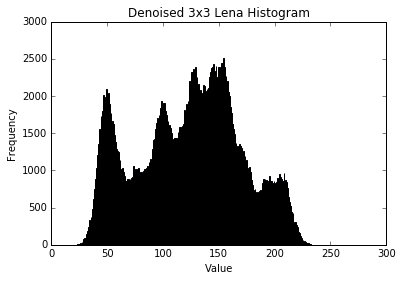

In [7]:
plot_histogram(noisy_lena_avg1, "Denoised 3x3 Lena Histogram")

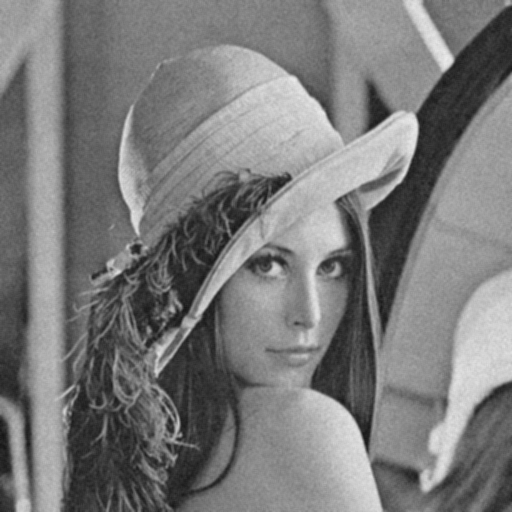

In [8]:
noisy_lena_avg1

### noisy lena convolved with 7x7 averaging filter

7x7 averaging filter:
PSNR between Lena and averaged Lena: 27.391849402900846



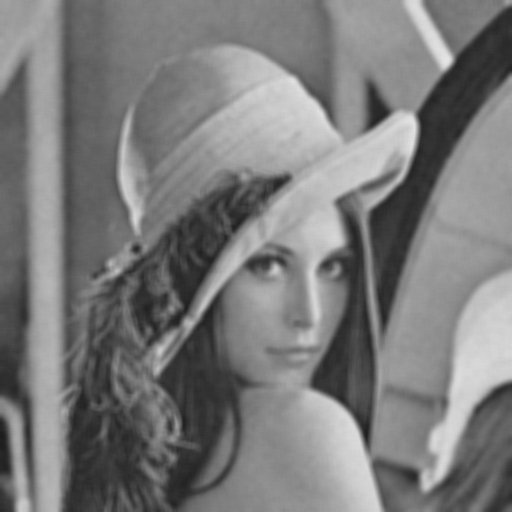

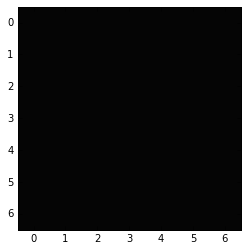

In [9]:
avg_7_7 = (1/(7*7))*np.ones([7,7])

print("7x7 averaging filter:")
imshow(Image.fromarray(avg_7_7 *255))

noisy_lena_avg2 = Image.fromarray(ndimage.convolve(np.array(noisy_lena), avg_7_7), 'L')

print("PSNR between Lena and averaged Lena: " + str(PSNR(lena, noisy_lena_avg2)) + "\n")

noisy_lena_avg2

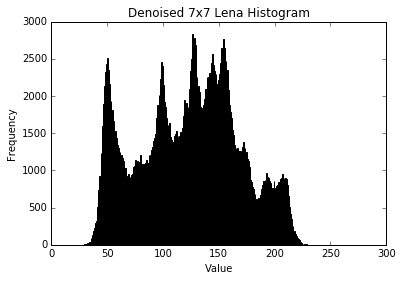

In [10]:
plot_histogram(noisy_lena_avg2, "Denoised 7x7 Lena Histogram")

### Gaussian 7x7 filter

7x7 gaussian filter:
PSNR between Lena and averaged Lena: 31.857035873715596



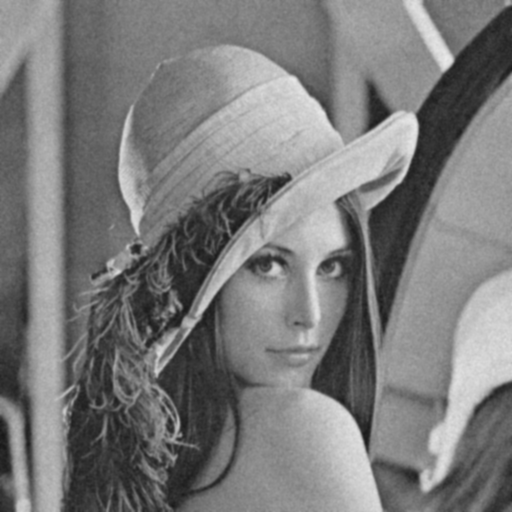

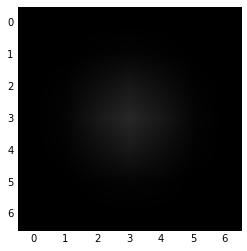

In [11]:
gaus =  np.array([[0.0000, 0.0002, 0.0011, 0.0018, 0.0011, 0.0002, 0.0000],
[0.0002, 0.0029, 0.0131, 0.0216, 0.0131, 0.0029, 0.0002],
[0.0011, 0.0131, 0.0586, 0.0966, 0.0586, 0.0131, 0.0011],
[0.0018, 0.0216, 0.0966, 0.1592, 0.0966, 0.0216, 0.0018],
[0.0011, 0.0131, 0.0586, 0.0966, 0.0586, 0.0131, 0.0011],
[0.0002, 0.0029, 0.0131, 0.0216, 0.0131, 0.0029, 0.0002],
[0.0000, 0.0002, 0.0011, 0.0018, 0.0011, 0.0002, 0.0000]]) # because python doesn't have an exact 'fspecial' equivalent

print("7x7 gaussian filter:")
imshow(Image.fromarray(gaus *255))

gaus_denoised = Image.fromarray(ndimage.convolve(np.array(noisy_lena), gaus), 'L')

print("PSNR between Lena and averaged Lena: " + str(PSNR(lena, gaus_denoised)) + "\n")

gaus_denoised

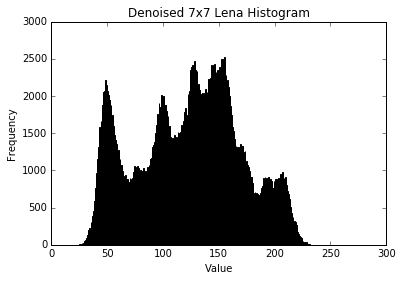

In [12]:
plot_histogram(gaus_denoised, "Denoised 7x7 Lena Histogram")

## Median Filter

PSNR between Lena and averaged Lena: 31.561760314430714



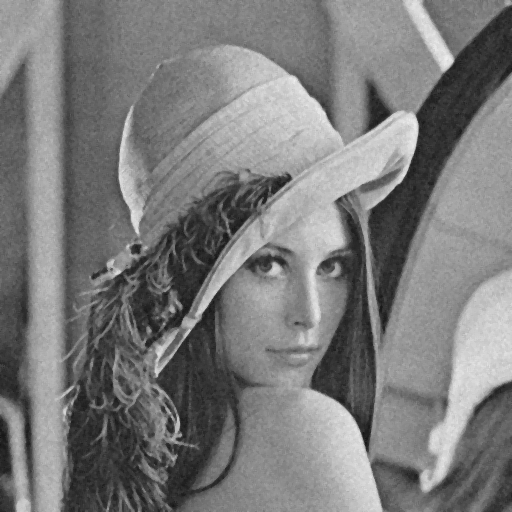

In [17]:
median_denoised = noisy_lena.filter(ImageFilter.MedianFilter())
print("PSNR between Lena and averaged Lena: " + str(PSNR(lena, median_denoised)) + "\n")
plot_histogram(median_denoised, "MedianDenoised Lena Histogram")
median_denoised